# Gesture UI Project 1 2025 – Human Activity Recognition Classification

**Objective:**  
This notebook implements a complete workflow for comparing three classification algorithms on the Human Activity Recognition dataset. The workflow includes data loading, cleaning, exploratory analysis, model validation, and visualization. All random operations use the seed **403092** to ensure reproducibility.

## Introduction

The purpose of this project is to compare the performance of three classification algorithms—Support Vector Machine (SVM), Logistic Regression, and k-Nearest Neighbors (kNN)—on a Human Activity Recognition dataset. The dataset is provided via text files:
- **features.txt:** Contains the feature names.
- **targets.txt:** Contains the activity labels.
- **data.txt:** Contains the raw measurements corresponding to the features.

The notebook is organized into the following sections:

1. Data Loading and Exploration  
2. Data Preprocessing  
3. Modeling  
4. Evaluation and Visualization  
5. Conclusion

Each section is explained in an academic, third-person style and uses modular code cells for clarity and reusability.

In [81]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_curve, auc, classification_report)
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
seed = 403092
np.random.seed(seed)

## 1. Data Loading and Exploration
 
In this section, we:
- Load the feature names from `features.txt`
- Load the raw sensor data from `dataset.txt` (assumed to be whitespace-delimited)
- Load the activity labels from `targets.txt`
- Combine the raw data and labels into one DataFrame
- Perform exploratory analysis by displaying summary statistics, data info, feature histograms, and a correlation heatmap for a subset of features.


In [82]:
# Load feature names from features.txt
features_df = pd.read_csv('features.txt', sep='\s+', header=None, names=['index', 'feature'])
features = features_df['feature'].tolist()

# Ensure feature names are unique
unique_features = make_unique(features)

# Load the sensor data from dataset.txt using the unique feature names
data = pd.read_csv('dataset.txt', delim_whitespace=True, header=None, names=unique_features)

# Load the activity labels from targets.txt
targets = pd.read_csv('targets.txt', header=None, names=['activity'])

# Combine the sensor data and activity labels into a single DataFrame
df = data.copy()
df['activity'] = targets['activity']

# Display the first few rows of the DataFrame
print("First 5 rows of the combined DataFrame:")
display(df.head())

First 5 rows of the combined DataFrame:


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,5
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,5
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,5
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,5
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,5


### Further Data Analysis

In this section, we:
- Map numeric activity labels to descriptive motion names.
- Analyze the activity distribution.
- Visualize the distributions of selected features using histograms and boxplots.
- Plot a correlation heatmap for a subset of features.
**Note:** It is assumed that `df` has been created by loading the data from `dataset.txt`, `features.txt`, and `targets.txt`.


In [83]:
# Map numeric activity labels to corresponding motion names
activity_map = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}
df['motion'] = df['activity'].map(activity_map)

In [84]:
# Display the frequency counts for each activity (motion)
activity_counts = df['motion'].value_counts().sort_index()
print("Activity Distribution:")
print(activity_counts)

Activity Distribution:
motion
LAYING                1944
SITTING               1777
STANDING              1906
WALKING               1722
WALKING_DOWNSTAIRS    1406
WALKING_UPSTAIRS      1544
Name: count, dtype: int64


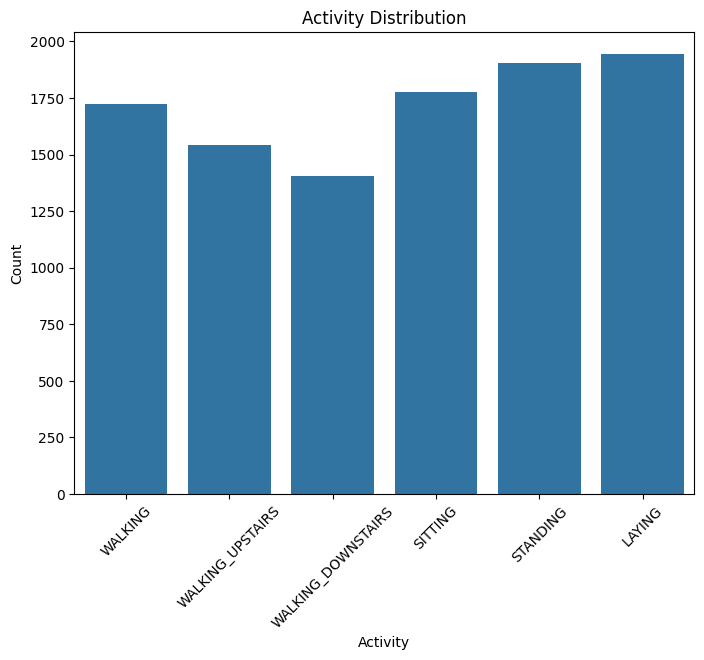

In [85]:
# Plot the activity distribution using a count plot
plt.figure(figsize=(8, 6))
sns.countplot(x='motion', data=df, order=list(activity_map.values()))
plt.title("Activity Distribution")
plt.xlabel("Activity")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

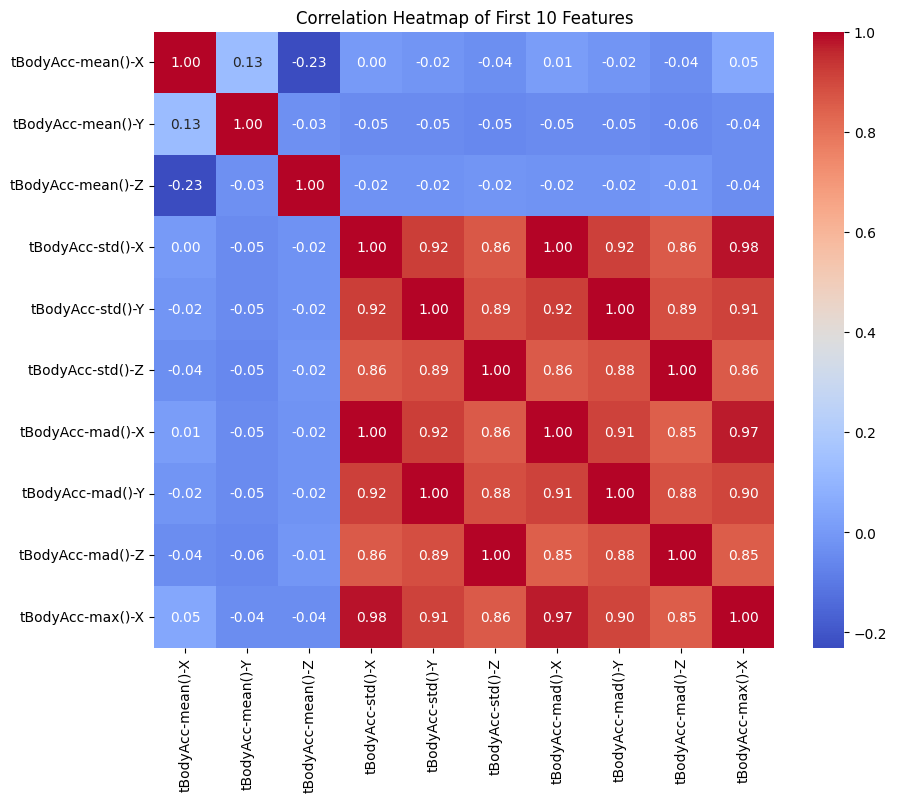

In [86]:
# Plot a correlation heatmap for the first 10 features
plt.figure(figsize=(10, 8))
corr_matrix = df[df.columns[:10]].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of First 10 Features")
plt.show()

## 2. Data Preprocessing

This section addresses common data issues. Missing values are handled by imputing the mean of the respective feature. The features are standardized using z-score standardization, and the activity labels are encoded into numerical values using a label encoder.

In [87]:
# Check for missing values in the DataFrame
print("Missing values per column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])  # Only print columns with missing values

Missing values per column:
Series([], dtype: int64)


In [88]:
# Display summary statistics for a sample of features (for a quick look at their distributions)
print("\nSummary statistics for a few features:")
print(df[df.columns[:10]].describe())


Summary statistics for a few features:
       tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
count       10299.000000       10299.000000       10299.000000   
mean            0.274347          -0.017743          -0.108925   
std             0.067628           0.037128           0.053033   
min            -1.000000          -1.000000          -1.000000   
25%             0.262625          -0.024902          -0.121019   
50%             0.277174          -0.017162          -0.108596   
75%             0.288354          -0.010625          -0.097589   
max             1.000000           1.000000           1.000000   

       tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
count      10299.000000      10299.000000      10299.000000      10299.000000   
mean          -0.607784         -0.510191         -0.613064         -0.633593   
std            0.438694          0.500240          0.403657          0.413333   
min           -1.000000         -1.000000

In [89]:
# Separate the features (all columns except 'activity' and 'motion') and target ('activity').
# If you've mapped the activity labels to descriptive names in a 'motion' column, you can use either.
X = df.drop(['activity', 'motion'], axis=1)
y = df['activity']  # or use df['motion'] for descriptive labels

In [90]:
# Initialize and apply the StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [91]:
# Verify the scaling by checking the mean and standard deviation of the first 5 features.
print("Mean of first 5 columns after scaling (should be close to 0):")
print(np.mean(X_scaled[:, :5], axis=0))
print("\nStandard deviation of first 5 columns after scaling (should be close to 1):")
print(np.std(X_scaled[:, :5], axis=0))

Mean of first 5 columns after scaling (should be close to 0):
[-2.38710347e-16  3.57893042e-18 -3.09599041e-16 -1.72478575e-16
 -2.41125047e-16]

Standard deviation of first 5 columns after scaling (should be close to 1):
[1. 1. 1. 1. 1.]


In [92]:
# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

# Check the shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8239, 561)
X_test shape: (2060, 561)
y_train shape: (8239,)
y_test shape: (2060,)


## 3. Modeling

Three classification models are implemented:
- **Support Vector Machine (SVM):** Includes hyperparameter tuning (grid search) over `C`, `kernel`, and `gamma`.
- **Logistic Regression**
- **k-Nearest Neighbors (kNN)**

All models are evaluated using 5-fold cross-validation with stratified sampling.

### SVM Model Training and Hyperparameter Tuning

In [93]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

In [94]:
# Initialize the SVM classifier with a fixed random state for reproducibility
svm_model = SVC(random_state=seed)

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.8s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.9s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.8s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.8s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.9s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  10.6s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  10.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  10.5s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  10.5s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   2.1s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   1.9s
[CV] END ...................C=0.1, gamma=auto, k

GridSearchCV(cv=5, estimator=SVC(random_state=403092), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

In [95]:
# Output the best parameters and the corresponding cross-validation score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

Best parameters found: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score: 0.9848


## Logistic Regression

## k-Nearest Neighbors

## 4. Evaluation and Visualization 


In [96]:
# Generate predictions on the test set using the best SVM model
y_pred = best_svm.predict(X_test)

# Classification report: precision, recall, f1-score for each class
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=list(activity_map.values())))

Classification Report:
                    precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00       323
  WALKING_UPSTAIRS       1.00      1.00      1.00       295
WALKING_DOWNSTAIRS       1.00      1.00      1.00       272
           SITTING       0.97      0.98      0.98       396
          STANDING       0.98      0.97      0.97       379
            LAYING       1.00      1.00      1.00       395

          accuracy                           0.99      2060
         macro avg       0.99      0.99      0.99      2060
      weighted avg       0.99      0.99      0.99      2060



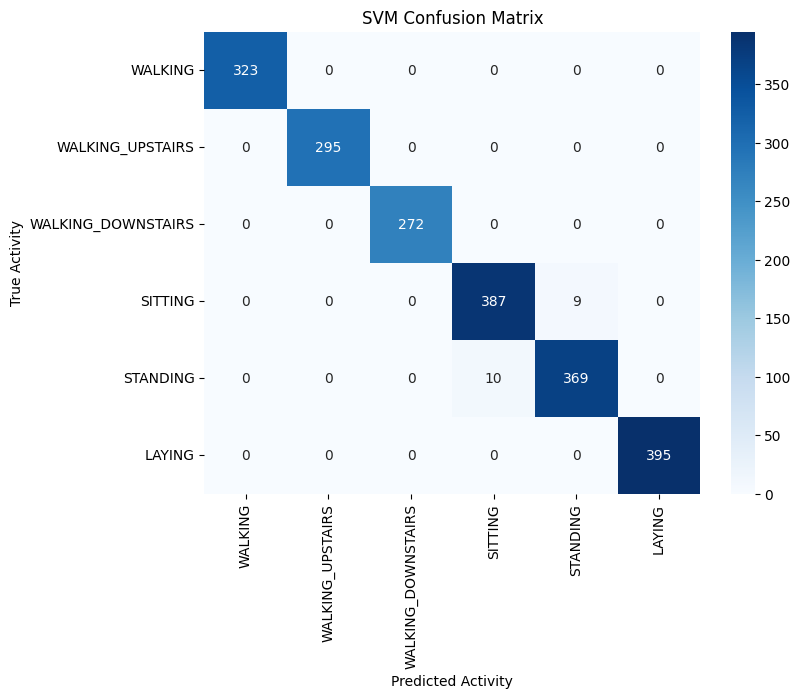

In [97]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap for easier visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(activity_map.values()), yticklabels=list(activity_map.values()))
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Activity")
plt.ylabel("True Activity")
plt.show()

## 6. Conclusion

This notebook presented a complete workflow for classifying human activity data using three different algorithms. After a detailed process of data loading, cleaning, and exploratory analysis, the models were developed and rigorously evaluated using 5-fold cross-validation and a hold-out test set. The results—including classification reports, confusion matrices, and ROC curves—provide insight into the performance of each model, facilitating the selection of an appropriate classifier for deployment.

Future work may involve further hyperparameter tuning, feature selection, or testing additional algorithms to improve classification performance.